# Advanced Regression Challenge

The task for this challenge is to evaluate the three different 'advanced' regression techniques recently learned - vanilla logistic regression, ridge logistic regression, and lasso logistic regression.


### Data and Motivation

Lack of grocery store availability, when coupled with a lack of other whole food vendors and transportation access, creates [food deserts](http://americannutritionassociation.org/newsletter/usda-defines-food-deserts).  People living within food deserts tend to rely more heavily on convienence stores for their sustenance needs.  These stores often have very short supplies of whole foods and large stocks of highly-processed, poor nutritional value foods.  Increased consumption of these sorts of foods has been linked to a wide variety of deliterious health effects such as obesity, high blood pressure, and heart disease.

We will be using the [Food Environment Atlas](https://catalog.data.gov/dataset/food-environment-atlas-f4a22) which is a compiled dataset by the US government covering a wide variety of food environment statistics at the county level.  Types of data included here are: store availability, restaurant availability & expenditures, food prices, and some basic socioeconomic characteristics.  

Our target variable will be grocery store availability, specifically `population, low access to store (% change), 2010-2015`.  This is defined as: 
>The percent change in the number of people in a county living more than 1 mile from a supermarket or large grocery store if in an urban area, or more than 10 miles from a supermarket or large grocery store if in a rural area. 

We will be looking to predict counties which have either gained or lost access to grocery stores over the 5 year period.


### Population with low access to a grocery store (% change from 2010-2015)
![title](GroceryStoreAvailabilityMap.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

# EDA

This dataset consists of multiple excel sheets which need to be loaded and examined individually.  The first one contains the target variable and all the following data loads will be for the predictors.

In [2]:
access = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=4, usecols=[0,1,2,5])

In [3]:
access.head()

,FIPS,State,County,PCH_LACCESS_POP_10_15
0,1001,AL,Autauga,-5.056026
1,1003,AL,Baldwin,-13.204891
2,1005,AL,Barbour,6.067799
3,1007,AL,Bibb,-7.224696
4,1009,AL,Blount,140.568857


In [4]:
access.describe()

,FIPS,PCH_LACCESS_POP_10_15
count,3143.000000,3.117000e+03
mean,30390.411709,7.180008e+03
std,15164.717720,3.955676e+05
min,1001.000000,-1.000000e+02
25%,18178.000000,-1.091343e+01
50%,29177.000000,-6.239322e-02
75%,45082.000000,7.262080e+00
max,56045.000000,2.208376e+07


In [5]:
access.shape

(3143, 4)

In [6]:
access.dtypes

FIPS                       int64
State                     object
County                    object
PCH_LACCESS_POP_10_15    float64
dtype: object

In [7]:
more = access['PCH_LACCESS_POP_10_15'][access['PCH_LACCESS_POP_10_15'] > 0].count()
zero = access['PCH_LACCESS_POP_10_15'][access['PCH_LACCESS_POP_10_15'] == 0].count()
less = access['PCH_LACCESS_POP_10_15'][access['PCH_LACCESS_POP_10_15'] < 0].count()

print('Greater than 0 count: ', more)
print('Equal to 0 count: ', zero)
print('Less than 0 count: ', less)

Greater than 0 count:  1255
Equal to 0 count:  256
Less than 0 count:  1606


In [8]:
# Creating the target variable for grocery store access, Rate decline = 1, Rate growth or 0 = 0
access['AccessDecline'] = np.where(access['PCH_LACCESS_POP_10_15'] < 0, 1, 0)

Now we have a binary target variable `AccessDecline` which represents counties that saw a decrease in available grocery stores per person.


# Predictor variables

In [9]:
# Grabbing store data
store = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=5, usecols=[0,5,17,29])

print(store.shape)
print(store.dtypes)
store.head()

(3143, 4)
FIPS                 int64
PCH_GROC_09_14     float64
PCH_CONVS_09_14    float64
PCH_SNAPS_12_16    float64
dtype: object


,FIPS,PCH_GROC_09_14,PCH_CONVS_09_14,PCH_SNAPS_12_16
0,1001,-33.333333,3.448276,12.694878
1,1003,20.833333,-0.840336,43.192771
2,1005,0.000000,35.714286,0.956938
3,1007,-16.666667,-21.052632,20.512821
4,1009,0.000000,-12.903226,23.903509


In [10]:
# Grabbing population data
pop = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=2, usecols=[0,1,2,3,8])

print(pop.shape)
print(pop.dtypes)
pop.head()

(3142, 5)
FIPS                          int64
State                        object
County                       object
2010 Census Population       object
Population Estimate, 2015    object
dtype: object


,FIPS,State,County,2010 Census Population,"Population Estimate, 2015"
0,1001,Alabama,Autauga,"54,571","55,035"
1,1003,Alabama,Baldwin,"182,265","203,690"
2,1005,Alabama,Barbour,"27,457","26,270"
3,1007,Alabama,Bibb,"22,915","22,561"
4,1009,Alabama,Blount,"57,322","57,676"


In [11]:
pop.columns

Index(['FIPS ', 'State', 'County', '2010 Census Population',
       'Population Estimate, 2015'],
      dtype='object')

In [12]:
# Converting population data to numeric
pop['Population Estimate, 2015'] = pop['Population Estimate, 2015'].astype('str')
pop['Population Estimate, 2015'] = pop['Population Estimate, 2015'].str.replace(',', '')
pop['Population Estimate, 2015'] = pd.to_numeric(pop['Population Estimate, 2015'])
pop['2010 Census Population'] = pop['2010 Census Population'].astype('str')
pop['2010 Census Population'] = pop['2010 Census Population'].str.replace(',', '')
pop['2010 Census Population'] = pd.to_numeric(pop['2010 Census Population'])

# Creating a population difference feature
pop['PopulationDiff'] = pop['Population Estimate, 2015'] - pop['2010 Census Population']

# Creating a separate dataframe from just the population difference
pop_variable = pd.DataFrame({
    'FIPS': pop['FIPS '],
    'PopDiff': pop['PopulationDiff']
})

In [13]:
# Grabbing socioeconomic data
socio = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=12)

print(socio.shape)
print(socio.dtypes)
socio.head()

(3143, 18)
FIPS                 int64
State               object
County              object
PCT_NHWHITE10      float64
PCT_NHBLACK10      float64
PCT_HISP10         float64
PCT_NHASIAN10      float64
PCT_NHNA10         float64
PCT_NHPI10         float64
PCT_65OLDER10      float64
PCT_18YOUNGER10    float64
MEDHHINC15         float64
POVRATE15          float64
PERPOV10             int64
CHILDPOVRATE15     float64
PERCHLDPOV10         int64
METRO13              int64
POPLOSS10          float64
dtype: object


,FIPS,State,County,PCT_NHWHITE10,PCT_NHBLACK10,PCT_HISP10,PCT_NHASIAN10,PCT_NHNA10,PCT_NHPI10,PCT_65OLDER10,PCT_18YOUNGER10,MEDHHINC15,POVRATE15,PERPOV10,CHILDPOVRATE15,PERCHLDPOV10,METRO13,POPLOSS10
0,1001,AL,Autauga,77.246156,17.582599,2.400542,0.855766,0.397647,0.040314,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0
1,1003,AL,Baldwin,83.504787,9.308425,4.384824,0.735193,0.628755,0.043343,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0
2,1005,AL,Barbour,46.753105,46.691190,5.051535,0.389700,0.218524,0.087409,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0
3,1007,AL,Bibb,75.020729,21.924504,1.771765,0.096007,0.279293,0.030548,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0
4,1009,AL,Blount,88.887338,1.263040,8.070200,0.200621,0.497191,0.031402,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0


In [14]:
# Percentage of majority white counties in US
socio['FIPS'][socio['PCT_NHWHITE10'] > 50].count() / 3143

0.8915049315940184

In [15]:
# Culling down the socio data to just a few columns
socio_small = pd.DataFrame({
    'FIPS': socio['FIPS'],
    'PCT_WHITE10': socio['PCT_NHWHITE10'],
    'PCT_65OLDER10': socio['PCT_65OLDER10'],
    'PCT_18YOUNGER10': socio['PCT_18YOUNGER10'],
    'MEDIANHOUSEINCOME': socio['MEDHHINC15'],
    'POVERTYRATE15': socio['POVRATE15'],
    'METRO13': socio['METRO13']
})

In [16]:
# Grabbing price data
price = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=9, usecols=[0,3,4])

print(price.shape)
print(price.dtypes)
price.head()

(3143, 3)
FIPS              int64
MILK_PRICE10    float64
SODA_PRICE10    float64
dtype: object


,FIPS,MILK_PRICE10,SODA_PRICE10
0,1001,0.970305,0.972216
1,1003,1.017690,1.001391
2,1005,1.136671,0.992584
3,1007,0.970305,0.972216
4,1009,0.970305,0.972216


In [17]:
# Grabbing local food scene data
farm = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=10, usecols=[0,5,16,50,59])

print(farm.shape)
print(farm.dtypes)
farm.head()

(3143, 5)
FIPS                          int64
PCH_DIRSALES_FARMS_07_12    float64
FMRKT09                     float64
FRESHVEG_FARMS12            float64
ORCHARD_FARMS12             float64
dtype: object


,FIPS,PCH_DIRSALES_FARMS_07_12,FMRKT09,FRESHVEG_FARMS12,ORCHARD_FARMS12
0,1001,104.000000,2.0,43.0,25.0
1,1003,28.750000,4.0,50.0,228.0
2,1005,-27.777778,2.0,7.0,58.0
3,1007,8.333333,1.0,10.0,4.0
4,1009,4.761905,1.0,59.0,28.0


In [18]:
# Grabbing health data
health = pd.read_excel("FoodEnvironmentAtlas.xls", sheet_name=11, usecols=[0,4,6,10])

print(health.shape)
print(health.dtypes)
health.head()

(3143, 4)
FIPS                       int64
PCT_DIABETES_ADULTS13    float64
PCT_OBESE_ADULTS13       float64
PCH_RECFAC_09_14         float64
dtype: object


,FIPS,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS13,PCH_RECFAC_09_14
0,1001,13.0,34.1,25.000000
1,1003,10.4,27.4,38.888889
2,1005,18.4,44.4,-100.000000
3,1007,14.8,40.3,0.000000
4,1009,14.1,34.6,0.000000


# Data Combination & Cleaning

In [19]:
data = access.iloc[:, [0,1,2,4]]

# Merging all the predictor variables
data = pd.merge(data, pop_variable, how='left', on='FIPS')
data = pd.merge(data, store, how='left', on='FIPS')
data = pd.merge(data, socio_small, how='left', on='FIPS')
data = pd.merge(data, price, how='left', on='FIPS')
data = pd.merge(data, farm, how='left', on='FIPS')
data = pd.merge(data, health, how='left', on='FIPS')

data.head()

,FIPS,State,County,AccessDecline,PopDiff,PCH_GROC_09_14,PCH_CONVS_09_14,PCH_SNAPS_12_16,PCT_WHITE10,PCT_65OLDER10,PCT_18YOUNGER10,MEDIANHOUSEINCOME,POVERTYRATE15,METRO13,MILK_PRICE10,SODA_PRICE10,PCH_DIRSALES_FARMS_07_12,FMRKT09,FRESHVEG_FARMS12,ORCHARD_FARMS12,PCT_DIABETES_ADULTS13,PCT_OBESE_ADULTS13,PCH_RECFAC_09_14
0,1001,AL,Autauga,1,464.0,-33.333333,3.448276,12.694878,77.246156,11.995382,26.777959,56580.0,12.7,1,0.970305,0.972216,104.000000,2.0,43.0,25.0,13.0,34.1,25.000000
1,1003,AL,Baldwin,1,21425.0,20.833333,-0.840336,43.192771,83.504787,16.771185,22.987408,52387.0,12.9,1,1.017690,1.001391,28.750000,4.0,50.0,228.0,10.4,27.4,38.888889
2,1005,AL,Barbour,0,-1187.0,0.000000,35.714286,0.956938,46.753105,14.236807,21.906982,31433.0,32.0,0,1.136671,0.992584,-27.777778,2.0,7.0,58.0,18.4,44.4,-100.000000
3,1007,AL,Bibb,1,-354.0,-16.666667,-21.052632,20.512821,75.020729,12.681650,22.696923,40767.0,22.2,1,0.970305,0.972216,8.333333,1.0,10.0,4.0,14.8,40.3,0.000000
4,1009,AL,Blount,0,354.0,0.000000,-12.903226,23.903509,88.887338,14.722096,24.608353,50487.0,14.7,1,0.970305,0.972216,4.761905,1.0,59.0,28.0,14.1,34.6,0.000000


In [20]:
data.columns = [
    'FIPS',
    'State',
    'County',
    'AccessDecline',
    'PopulationDiff',
    'PctChGroceryStores_09_14',
    'PctChConvStores_09_14',
    'PctChSNAPStores_12_16',
    'PctWhite_10',
    'PctOver65_10',
    'PctUnder18_10',
    'MedHouseholdIncome_15',
    'PovertyRate_15',
    'MetroCounty_13',
    'MilkPrice_10',
    'SodaPrice_10',
    'PctChDirectFarmSales_07_12',
    'FarmerMkts_09',
    'FreshVegFarms_12',
    'OrchardFarms_12',
    'PctAdultDiabetes_13',
    'PctAdultObese_13',
    'PctChRecFacilities_09_14'
]

In [21]:
# Checking for nulls
columns = data.columns
for col in columns:
    print(col, ':', data[col].isna().sum())
print('\nTotal Counties: ', data.shape[0])

FIPS : 0
State : 0
County : 0
AccessDecline : 0
PopulationDiff : 3
PctChGroceryStores_09_14 : 20
PctChConvStores_09_14 : 24
PctChSNAPStores_12_16 : 29
PctWhite_10 : 0
PctOver65_10 : 0
PctUnder18_10 : 0
MedHouseholdIncome_15 : 4
PovertyRate_15 : 4
MetroCounty_13 : 0
MilkPrice_10 : 34
SodaPrice_10 : 34
PctChDirectFarmSales_07_12 : 124
FarmerMkts_09 : 6
FreshVegFarms_12 : 63
OrchardFarms_12 : 63
PctAdultDiabetes_13 : 1
PctAdultObese_13 : 1
PctChRecFacilities_09_14 : 123

Total Counties:  3143


In [22]:
# Dropping all the missing data loses ~10% of the data

# data = data.dropna()
# data.shape[0] / 3143
# 0.905

In [23]:
# Grouping all the missing data by state to assess the most affected states
for col in columns:
    if data[col].isna().sum() != 0:
        print(col)
        print(data[['County', 'State']][data[col].isna()].groupby('State').count())
        print('\n')


PopulationDiff
       County
State        
AK          1
SD          1
VA          1


PctChGroceryStores_09_14
       County
State        
AK          5
AL          1
CO          1
GA          2
KS          3
ND          1
NE          1
TX          3
VA          3


PctChConvStores_09_14
       County
State        
AK          6
CO          1
GA          1
KS          3
MT          2
ND          3
NE          2
OR          2
SD          1
TX          1
UT          1
WA          1


PctChSNAPStores_12_16
       County
State        
AK          1
CA          1
CO          1
HI          1
ID          1
KS          1
MT          2
ND          3
NE          8
NV          1
SD          1
TX          8


MedHouseholdIncome_15
       County
State        
AK          1
HI          1
SD          1
VA          1


PovertyRate_15
       County
State        
AK          1
HI          1
SD          1
VA          1


MilkPrice_10
       County
State        
AK         29
HI          5


SodaPrice_10

Alaska and Hawaii will be dropped completely because they do not have milk or soda data.  Washington D.C. will be removed because it doesn't have any state data to impute with.  The other most affected states are Texas, Virginia, and Georgia, but all missing data will be imputed.

In [24]:
data = data[data['State'] != 'AK']
data = data[data['State'] != 'HI']
data = data[data['State'] != 'DC']
data.shape

(3108, 23)

In [25]:
# Imputing the missing data with state-wide means
imputing_list = ['PopulationDiff', 
                 'PctChGroceryStores_09_14',
                 'PctChConvStores_09_14',
                 'PctChSNAPStores_12_16',
                 'MedHouseholdIncome_15',
                 'PovertyRate_15',
                 'PctChDirectFarmSales_07_12',
                 'FarmerMkts_09',
                 'FreshVegFarms_12',
                 'OrchardFarms_12',
                 'PctAdultDiabetes_13',
                 'PctAdultObese_13',
                 'PctChRecFacilities_09_14']

def impute(df, im_list):
    missing_data = None
    states = []
    state_mean = {}
    missing_state = None
    idx = None
    
    for i in im_list:
        missing_data = df[df[i].isna() == True]
        for j in range(len(missing_data)):
            states.append(missing_data.iloc[j, 1])
        for s in states:
            state_mean[s] = df[i][df['State'] == s].mean()
        for md in range(len(missing_data)):
            missing_state = missing_data.iloc[md, 1]
            idx = missing_data.index[md]
            df.loc[idx, i] = state_mean[missing_state]
    
    return df

impute(data, imputing_list)

# Checking the results of the imputation
for col in columns:
    print(col, ':', data[col].isna().sum())
print('\nTotal Counties: ', data.shape[0])

FIPS : 0
State : 0
County : 0
AccessDecline : 0
PopulationDiff : 0
PctChGroceryStores_09_14 : 0
PctChConvStores_09_14 : 0
PctChSNAPStores_12_16 : 0
PctWhite_10 : 0
PctOver65_10 : 0
PctUnder18_10 : 0
MedHouseholdIncome_15 : 0
PovertyRate_15 : 0
MetroCounty_13 : 0
MilkPrice_10 : 0
SodaPrice_10 : 0
PctChDirectFarmSales_07_12 : 0
FarmerMkts_09 : 0
FreshVegFarms_12 : 0
OrchardFarms_12 : 0
PctAdultDiabetes_13 : 0
PctAdultObese_13 : 0
PctChRecFacilities_09_14 : 0

Total Counties:  3108


# EDA in earnest

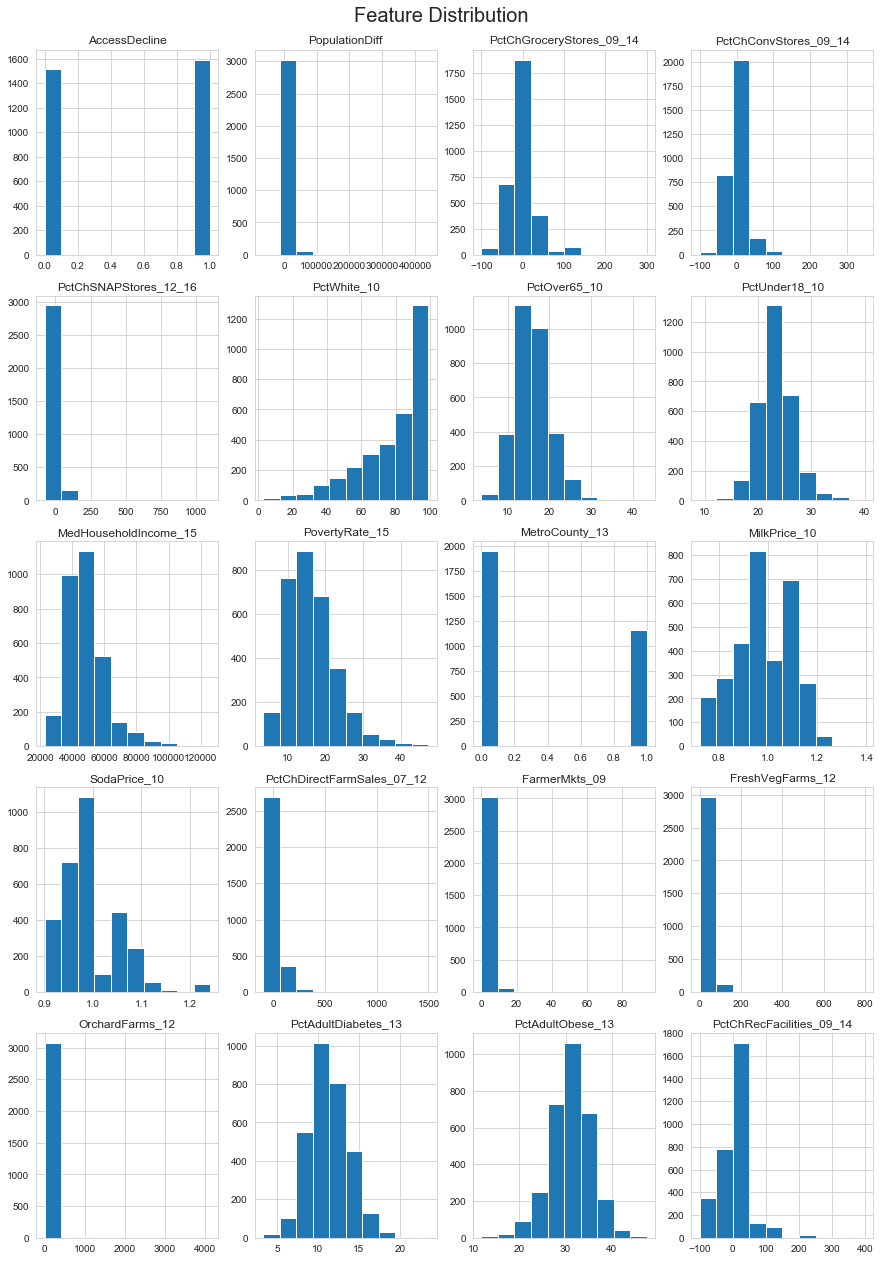

In [26]:
plt.figure(figsize=(15,20))
plt.suptitle('Feature Distribution', size=20)

for i in range(3, 23):
    plt.subplot(5,4,(i-2))
    plt.title(data.columns[i])
    plt.hist(data.iloc[:, i])
    
plt.subplots_adjust(top=0.95)
#plt.tight_layout()
plt.show()

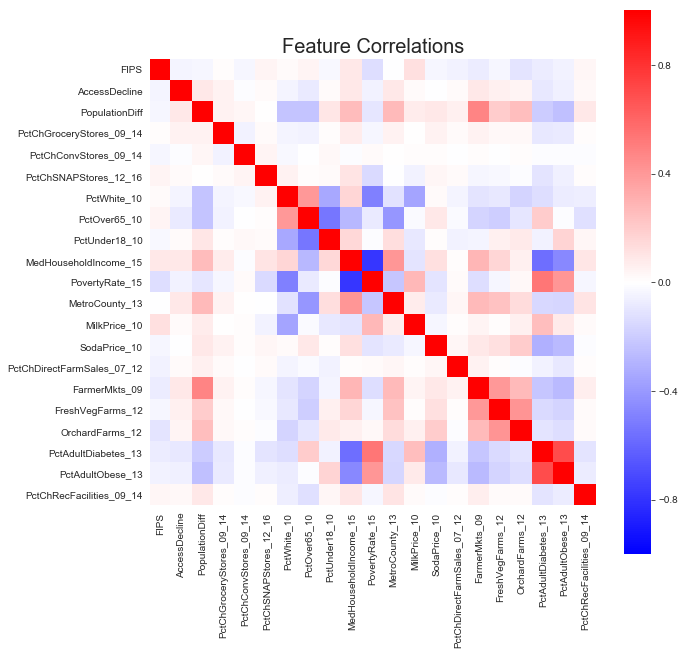

In [27]:
plt.figure(figsize=(10,10))
plt.title('Feature Correlations', size=20)
sns.heatmap(data.corr(), cmap='bwr', vmin=-1, vmax=1, square=True)
plt.show()

It's incredibly surprisingly how little correlation these input features have with each other.  The strongest correlations are between `MedianIncome`&`PovertyRate`, `Obesity`&`Diabetes`, those health features & the income features, and `PercentOver65`&`PercentUnder18`.  We shouldn't have to do any dimensionality reduction because of the low correlations.

We also see that the features all have their own distributions.  We will scale all the features, except the target `AccessDecline`, prior to modelling.


# Preprocessing & Train/Validation/Test Splits

In [28]:
from sklearn import preprocessing

data_scaled = preprocessing.scale(data.iloc[:,4:])
data.iloc[:,4:] = data_scaled
data.describe()

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


,FIPS,AccessDecline,PopulationDiff,PctChGroceryStores_09_14,PctChConvStores_09_14,PctChSNAPStores_12_16,PctWhite_10,PctOver65_10,PctUnder18_10,MedHouseholdIncome_15,PovertyRate_15,MetroCounty_13,MilkPrice_10,SodaPrice_10,PctChDirectFarmSales_07_12,FarmerMkts_09,FreshVegFarms_12,OrchardFarms_12,PctAdultDiabetes_13,PctAdultObese_13,PctChRecFacilities_09_14
count,3108.000000,3108.000000,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03,3.108000e+03
mean,30684.873230,0.512548,3.533746e-17,1.446340e-16,-8.244513e-17,-1.443147e-17,-3.030966e-16,5.197752e-19,-1.987542e-16,1.786073e-16,-4.604496e-16,4.653078e-16,-6.191958e-16,3.486415e-17,-7.115715e-17,-5.000335e-16,6.562032e-17,-2.018888e-16,2.840213e-16,9.570851e-16,2.979170e-16
std,14984.274593,0.499923,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00,1.000161e+00
min,1001.000000,0.000000,-3.536398e+00,-2.914719e+00,-3.366462e+00,-2.900689e+00,-3.885163e+00,-2.955148e+00,-4.329798e+00,-2.083916e+00,-2.002144e+00,-7.716752e-01,-2.084779e+00,-1.539672e+00,-1.355387e+00,-4.190564e-01,-5.437198e-01,-2.010996e-01,-3.244504e+00,-4.257664e+00,-1.902812e+00
25%,19046.500000,0.000000,-2.250796e-01,-5.368686e-01,-4.729339e-01,-3.801846e-01,-5.810209e-01,-6.656945e-01,-6.017782e-01,-6.617592e-01,-7.288086e-01,-7.716752e-01,-8.233360e-01,-7.042411e-01,-4.411971e-01,-4.190564e-01,-4.401692e-01,-1.829785e-01,-6.832052e-01,-5.879759e-01,-3.879158e-01
50%,29214.000000,1.000000,-2.051101e-01,5.759411e-02,-8.713012e-02,-1.088804e-01,3.737877e-01,-8.311054e-02,-2.910044e-02,-1.438869e-01,-1.697834e-01,-7.716752e-01,-1.931630e-02,-2.870584e-01,-1.628053e-01,-1.648093e-01,-2.589557e-01,-1.467362e-01,-7.337213e-02,3.747625e-02,1.170496e-01
75%,46009.500000,1.000000,-1.537693e-01,2.433637e-01,2.914128e-01,2.572632e-01,8.000188e-01,5.586139e-01,5.079106e-01,4.519200e-01,5.328803e-01,1.295882e+00,9.099511e-01,7.938898e-01,1.939500e-01,8.943784e-02,5.169597e-02,-7.425156e-02,6.584276e-01,6.352535e-01,1.170496e-01
max,56045.000000,1.000000,2.293589e+01,8.974534e+00,1.139053e+01,3.672364e+01,1.050911e+00,6.633113e+00,5.061706e+00,6.311088e+00,4.830387e+00,1.295882e+00,3.513837e+00,4.237481e+00,1.723666e+01,2.348017e+01,2.021817e+01,2.470944e+01,4.967915e+00,3.668420e+00,8.196496e+00


In [29]:
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

print(len(train))
print(len(validate))
print(len(test))

1864
622
622


In [30]:
# Setting up the X & Y features

Y_train = np.array(train.iloc[:,3]).ravel()
Y_validate = np.array(validate.iloc[:,3]).ravel()
Y_test = np.array(test.iloc[:,3]).ravel()

# Creating a singular X group with just population change
X_pop_train = np.array(train.iloc[:,4]).reshape(-1,1)
X_pop_validate = np.array(validate.iloc[:,4]).reshape(-1,1)
X_pop_test = np.array(test.iloc[:,4]).reshape(-1,1)

# Creating a singular X group with just grocery store change
X_grocery_train = np.array(train.iloc[:,5]).reshape(-1,1)
X_grocery_validate = np.array(validate.iloc[:,5]).reshape(-1,1)
X_grocery_test = np.array(test.iloc[:,5]).reshape(-1,1)

# Creating the baseline X group with all other features
X_train = np.array(train.iloc[:,6:])
X_validate = np.array(validate.iloc[:,6:])
X_test = np.array(test.iloc[:,6:])

# Initial Models

My initial assumption is that the key drivers behind changing access levels to grocery stores are, 1) Population change, and, 2) Grocery store changes.  If people leave or move to a new location, they will change the access levels of both their previous location and their new location.  Likewise, grocery stores closing and opening is the primary driver behind the access levels.

Because these two variables are likely to be the primary features, I want to hold them out of the model.  But, I also want to test how critical each are to the changing grocery store access levels.  So, I will create two simple models, one with each feature, prior to making the more comprehensive model.

In [31]:
from sklearn import linear_model

# Model with just the population change
logr_pop = linear_model.LogisticRegression(solver='liblinear', C=1e9, fit_intercept=False)
logr_pop.fit(X_pop_train, Y_train)
print('R^2 population model: ', logr_pop.score(X_pop_validate, Y_validate))

# Model with just the grocery change
logr_grocery = linear_model.LogisticRegression(solver='liblinear', C=1e9, fit_intercept=False)
logr_grocery.fit(X_grocery_train, Y_train)
print('R^2 grocery model: ', logr_grocery.score(X_grocery_validate, Y_validate))


R^2 population model:  0.5594855305466238
R^2 grocery model:  0.5369774919614148


Hmmm...surprisingly those features don't really make the model better than a random guess.  Let's combine these features in a simple, two feature model, to see if we can get a better model fit.

In [32]:
# Model with both population and grocery change
X_popgroc_train = np.array(train.iloc[:,4:5])
X_popgroc_validate = np.array(validate.iloc[:,4:5])

logr_popgroc = linear_model.LogisticRegression(solver='liblinear', C=1e9)
logr_popgroc.fit(X_popgroc_train, Y_train)
print('R^2 population-grocery model: ', logr_popgroc.score(X_popgroc_validate, Y_validate))

R^2 population-grocery model:  0.545016077170418


This splits the difference between the two individual models.

Perhaps these features have a place in the full model?  We'll keep them out for now, but keep this thought in mind if don't have great predictive power with the full model.

In [33]:
# Model with all features except population and grocery change
logr_full = linear_model.LogisticRegression(solver='liblinear', C=1e9)
logr_full.fit(X_train, Y_train)
print('R^2 full model: ', logr_full.score(X_validate, Y_validate))

R^2 full model:  0.5659163987138264


Well, that's not very good either.  But atleast is is a smidge better that the "simple" models.  Let's check a ridge regression with varying C values.

In [34]:
# Testing a variety of c values for the ridge model with all features except 
# population & grocery changes
c_range = [100, 10, 1, .75, .5, .35, .25, .2, .15, .1, .05, .04, 
           .03, .025, .0225, .02, .0175, .015, .01, .001, .0001]

print('C value :', 'R^2')
for c in c_range:
    logr_full_ridge = linear_model.LogisticRegression(solver='liblinear', penalty='l2', C=c)
    logr_full_ridge.fit(X_train, Y_train)
    print(c, 
          '\t:', 
          logr_full_ridge.score(X_validate, Y_validate)
         )


C value : R^2
100 	: 0.5659163987138264
10 	: 0.5659163987138264
1 	: 0.5659163987138264
0.75 	: 0.5659163987138264
0.5 	: 0.5627009646302251
0.35 	: 0.5627009646302251
0.25 	: 0.5643086816720257
0.2 	: 0.5643086816720257
0.15 	: 0.5659163987138264
0.1 	: 0.5659163987138264
0.05 	: 0.5659163987138264
0.04 	: 0.567524115755627
0.03 	: 0.5627009646302251
0.025 	: 0.5627009646302251
0.0225 	: 0.5627009646302251
0.02 	: 0.5610932475884244
0.0175 	: 0.5578778135048231
0.015 	: 0.5562700964630225
0.01 	: 0.5578778135048231
0.001 	: 0.567524115755627
0.0001 	: 0.5627009646302251


The best (liblinear) model is at `C=0.04` but it has essentially the same score as the vanilla logistic regression.

In [35]:
# Testings a variety of c values for the lasso model with all features except 
# population & grocery changes

print('C value :', 'R^2\t\t\t:', '# of model features')
for c in c_range:
    logr_full_lasso = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
    logr_full_lasso.fit(X_train, Y_train)
    print(c, 
          '\t:', 
          logr_full_lasso.score(X_validate, Y_validate), 
          '\t:', 
          (logr_full_lasso.coef_ != 0).sum()
         )

C value : R^2			: # of model features
100 	: 0.5659163987138264 	: 17
10 	: 0.567524115755627 	: 17
1 	: 0.5691318327974276 	: 16
0.75 	: 0.567524115755627 	: 16
0.5 	: 0.5691318327974276 	: 16
0.35 	: 0.567524115755627 	: 14
0.25 	: 0.5610932475884244 	: 14
0.2 	: 0.5594855305466238 	: 14
0.15 	: 0.5530546623794212 	: 15
0.1 	: 0.5498392282958199 	: 13
0.05 	: 0.5707395498392283 	: 11
0.04 	: 0.5707395498392283 	: 8
0.03 	: 0.5610932475884244 	: 4
0.025 	: 0.5514469453376206 	: 3
0.0225 	: 0.5498392282958199 	: 3
0.02 	: 0.5482315112540193 	: 3
0.0175 	: 0.5466237942122186 	: 3
0.015 	: 0.5466237942122186 	: 1
0.01 	: 0.4903536977491961 	: 0
0.001 	: 0.4903536977491961 	: 0
0.0001 	: 0.4903536977491961 	: 0


The best lasso model is somewhere in between `C=0.05` and `C=0.04`, which keeps between 8 & 11 features in the model.  $R^2$ score is the highest we've seen so far at 0.57.

# Poor model performance

We do not have very good performance.  We will add in the population and grocery store change data into the predictor feature set.  And we will also examine the performance of all the potential 'solver' algorithms present in SKlearn.

In [36]:
# Creating the baseline X group with the complete set of features
X_complete_train = np.array(train.iloc[:,4:])
X_complete_validate = np.array(validate.iloc[:,4:])
X_complete_test = np.array(test.iloc[:,4:])

In [37]:
# Testing ridge with the complete set of features

print('C value :', 'R^2')
for c in c_range:
    logr_complete_ridge = linear_model.LogisticRegression(solver='liblinear', penalty='l2', C=c)
    logr_complete_ridge.fit(X_complete_train, Y_train)
    print(c, 
          '\t:', 
          logr_complete_ridge.score(X_complete_validate, Y_validate)
         )

C value : R^2
100 	: 0.5659163987138264
10 	: 0.5659163987138264
1 	: 0.5643086816720257
0.75 	: 0.5643086816720257
0.5 	: 0.5643086816720257
0.35 	: 0.5643086816720257
0.25 	: 0.5627009646302251
0.2 	: 0.5643086816720257
0.15 	: 0.5659163987138264
0.1 	: 0.5643086816720257
0.05 	: 0.5594855305466238
0.04 	: 0.5594855305466238
0.03 	: 0.5627009646302251
0.025 	: 0.5659163987138264
0.0225 	: 0.5594855305466238
0.02 	: 0.5594855305466238
0.0175 	: 0.5594855305466238
0.015 	: 0.5578778135048231
0.01 	: 0.5562700964630225
0.001 	: 0.5610932475884244
0.0001 	: 0.5578778135048231


Interestingly the ridge model performs worse with the population and grocery store change features included.  Here we see the best model performance at high C values, which is equivalent to a vanilla regression.

In [38]:
# Testings the lasso model with the complete set of features

print('C value :', 'R^2\t\t\t:', '# of model features')
for c in c_range:
    logr_complete_lasso = linear_model.LogisticRegression(solver='liblinear', penalty='l1', C=c)
    logr_complete_lasso.fit(X_complete_train, Y_train)
    print(c, 
          '\t:', 
          logr_complete_lasso.score(X_complete_validate, Y_validate), 
          '\t:', (logr_complete_lasso.coef_ != 0).sum()
         )

C value : R^2			: # of model features
100 	: 0.5659163987138264 	: 19
10 	: 0.5643086816720257 	: 19
1 	: 0.5643086816720257 	: 17
0.75 	: 0.5643086816720257 	: 17
0.5 	: 0.5610932475884244 	: 17
0.35 	: 0.5627009646302251 	: 17
0.25 	: 0.5627009646302251 	: 16
0.2 	: 0.567524115755627 	: 16
0.15 	: 0.5594855305466238 	: 16
0.1 	: 0.5562700964630225 	: 17
0.05 	: 0.5594855305466238 	: 11
0.04 	: 0.5627009646302251 	: 10
0.03 	: 0.5514469453376206 	: 6
0.025 	: 0.5498392282958199 	: 4
0.0225 	: 0.5498392282958199 	: 4
0.02 	: 0.5482315112540193 	: 3
0.0175 	: 0.5466237942122186 	: 3
0.015 	: 0.5466237942122186 	: 1
0.01 	: 0.4903536977491961 	: 0
0.001 	: 0.4903536977491961 	: 0
0.0001 	: 0.4903536977491961 	: 0


Likewise, the lasso model performance degrades with the additional features.  The best performance here is at `C=0.2` which keeps 16 features in the model.

In [39]:
# Testing the different solver methods for a ridge model with the complete set of features

ridge_solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for solv in range(len(ridge_solvers)):
    print('\n', ridge_solvers[solv])
    print('C value :', 'R^2')
    for c in c_range:
        logr_complete_ridge = linear_model.LogisticRegression(solver=ridge_solvers[solv], penalty='l2', C=c)
        logr_complete_ridge.fit(X_complete_train, Y_train)
        print(c, 
              '\t:', 
              logr_complete_ridge.score(X_complete_validate, Y_validate)
             )


 newton-cg
C value : R^2
100 	: 0.5659163987138264
10 	: 0.5659163987138264
1 	: 0.5643086816720257
0.75 	: 0.5643086816720257
0.5 	: 0.5643086816720257
0.35 	: 0.5643086816720257
0.25 	: 0.5627009646302251
0.2 	: 0.5627009646302251
0.15 	: 0.5643086816720257
0.1 	: 0.5627009646302251
0.05 	: 0.5610932475884244
0.04 	: 0.5594855305466238
0.03 	: 0.5594855305466238
0.025 	: 0.5610932475884244
0.0225 	: 0.5643086816720257
0.02 	: 0.5610932475884244
0.0175 	: 0.5562700964630225
0.015 	: 0.5530546623794212
0.01 	: 0.5546623794212219
0.001 	: 0.5691318327974276
0.0001 	: 0.5128617363344051

 lbfgs
C value : R^2
100 	: 0.5659163987138264
10 	: 0.5659163987138264
1 	: 0.5643086816720257
0.75 	: 0.5643086816720257
0.5 	: 0.5643086816720257
0.35 	: 0.5643086816720257
0.25 	: 0.5627009646302251
0.2 	: 0.5627009646302251
0.15 	: 0.5643086816720257
0.1 	: 0.5627009646302251
0.05 	: 0.5610932475884244
0.04 	: 0.5594855305466238
0.03 	: 0.5594855305466238
0.025 	: 0.5610932475884244
0.0225 	: 0.564

All the ridge regression solvers land on similar solutions with _very_ minor changes in predictive power.

**solver == C value == $R^2$ score**

newton-cg == 0.001 == 0.569

lbfgs == 0.001 == 0.569

liblinear == many (high & low) == 0.566

sag == many (high) == 0.566

saga == 0.001 == 0.567


In [40]:
# Testing the different solver methods for a lasso model with the complete set of features

lasso_solvers = ['liblinear', 'saga']

for solv in range(len(lasso_solvers)):
    print('\n', lasso_solvers[solv])
    print('C value :', 'R^2\t\t\t:', '# of model features')
    for c in c_range:
        logr_complete_lasso = linear_model.LogisticRegression(solver=lasso_solvers[solv], penalty='l1', C=c)
        logr_complete_lasso.fit(X_complete_train, Y_train)
        print(c, 
              '\t:', 
              logr_complete_lasso.score(X_complete_validate, Y_validate),
              '\t:', (logr_complete_lasso.coef_ != 0).sum()
             )


 liblinear
C value : R^2			: # of model features
100 	: 0.5659163987138264 	: 19
10 	: 0.5643086816720257 	: 19
1 	: 0.5643086816720257 	: 17
0.75 	: 0.5643086816720257 	: 17
0.5 	: 0.5610932475884244 	: 17
0.35 	: 0.5627009646302251 	: 17
0.25 	: 0.5643086816720257 	: 16
0.2 	: 0.567524115755627 	: 16
0.15 	: 0.5594855305466238 	: 16
0.1 	: 0.5562700964630225 	: 17
0.05 	: 0.5594855305466238 	: 11
0.04 	: 0.5627009646302251 	: 10
0.03 	: 0.5514469453376206 	: 6
0.025 	: 0.5498392282958199 	: 4
0.0225 	: 0.5498392282958199 	: 4
0.02 	: 0.5482315112540193 	: 3
0.0175 	: 0.5466237942122186 	: 3
0.015 	: 0.5466237942122186 	: 1
0.01 	: 0.4903536977491961 	: 0
0.001 	: 0.4903536977491961 	: 0
0.0001 	: 0.4903536977491961 	: 0

 saga
C value : R^2			: # of model features
100 	: 0.5659163987138264 	: 19
10 	: 0.5643086816720257 	: 19
1 	: 0.5627009646302251 	: 17
0.75 	: 0.5610932475884244 	: 17
0.5 	: 0.5578778135048231 	: 17
0.35 	: 0.5546623794212219 	: 17
0.25 	: 0.5594855305466238 	: 1

The lasso models don't vary much in their predictive power, though the `saga` solver appears to do marginally better than `liblinear`.

**solver == C value == $R^2$ score**

liblinear == 100 == 0.566

saga == 0.0225 == 0.569

# More Feature Engineering needed

We have a slew of poor-performing models.  Based on $R^2$ scores for the validation data the best models are:
1. Lasso: $R^2 = 0.571$, `liblinear, C=0.04`, all features except population and grocery changes
2. Ridge: $R^2 = 0.569$, `newton-cg & lbfgs, C=0.001`, complete feature set
3. Lasso: $R^2 = 0.569$, `saga, C=0.0225`, complete feature set
4. Many models: $R^2 = 0.560 - 0.565$

This suggests a need for more predictive features.  Once again, this problem is a business problem -- what are the main business drivers for grocery store chains in deciding to close existing stores or open new stores.  I think that feeding the model more economic data will be productive.

To that end, I will load some addtional county level data.  First, we'll take economic data from [American FactFinder](https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=BP_2015_00A1&prodType=table), a data store for US census-related data.  Specifically, we will add a feature for the change in annual county payrolls across all industries.  Secondly, will also add an income inequality feature, the [Gini index](https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_15_5YR_B19083&prodType=table).  Then we'll load unemployement data from the [USDA ERS](https://www.ers.usda.gov/data-products/atlas-of-rural-and-small-town-america/download-the-data/).  Finally, we'll bring in some county-level classification data on urban influence and main economic drivers, also from the USDA ERS.


### County Payroll Data
We're going to calculate the difference in county-level payroll data from 2010 to 2015.  This tracks the change in how much money county citizens have at their disposal, but it isn't normalized by total population.

In [41]:
# Pulling in the county level payroll data
county10 = pd.read_csv('./BP_2010_00A1/BP_2010_00A1_with_ann.csv', 
                       header = 1,
                       usecols = [1,9])
county10.columns = ['FIPS', 'AnnualPayroll_2010_1000']

county15 = pd.read_csv('./BP_2015_00A1/BP_2015_00A1_with_ann.csv', 
                       header = 1,
                       usecols = [1,9]) 
county15.columns = ['FIPS', 'AnnualPayroll_2015_1000']

In [42]:
county_payroll = pd.merge(county10, county15, how='inner', on='FIPS')

# Some data is has been replaced with 'D' so as to note disclose specific companies
# Converting those to blanks and the columns to numeric
county_payroll['AnnualPayroll_2010_1000'] = county_payroll['AnnualPayroll_2010_1000'
                                                          ].str.replace('D', '', regex=False)
county_payroll['AnnualPayroll_2015_1000'] = county_payroll['AnnualPayroll_2015_1000'
                                                          ].str.replace('D', '', regex=False)

county_payroll['AnnualPayroll_2010_1000'] = pd.to_numeric(county_payroll['AnnualPayroll_2010_1000'])
county_payroll['AnnualPayroll_2015_1000'] = pd.to_numeric(county_payroll['AnnualPayroll_2015_1000'])

# Calculating the difference between 2015 and 2010 county payrolls
county_payroll['PayrollDiff'] = county_payroll['AnnualPayroll_2010_1000'] - county_payroll['AnnualPayroll_2015_1000']

county_payroll_diff = pd.DataFrame({
    'FIPS': county_payroll['FIPS'],
    'PayrollDiff': county_payroll['PayrollDiff']
})

In [43]:
data_additional = pd.merge(data, county_payroll_diff, how='left', on='FIPS')
data_additional.head()

,FIPS,State,County,AccessDecline,PopulationDiff,PctChGroceryStores_09_14,PctChConvStores_09_14,PctChSNAPStores_12_16,PctWhite_10,PctOver65_10,PctUnder18_10,MedHouseholdIncome_15,PovertyRate_15,MetroCounty_13,MilkPrice_10,SodaPrice_10,PctChDirectFarmSales_07_12,FarmerMkts_09,FreshVegFarms_12,OrchardFarms_12,PctAdultDiabetes_13,PctAdultObese_13,PctChRecFacilities_09_14,PayrollDiff
0,1001,AL,Autauga,1,-0.178265,-0.933177,0.025950,0.102464,-0.071810,-0.956190,1.019620,0.661498,-0.557995,1.295882,-0.019316,-0.331256,1.015099,0.089438,0.569449,-0.050090,0.699083,0.679533,0.622015,-48381.0
1,1003,AL,Baldwin,1,0.921816,0.676826,-0.114688,1.129654,0.248795,0.198502,-0.128165,0.319767,-0.526938,1.295882,0.374826,0.163778,0.140692,0.597932,0.750662,1.176108,-0.357961,-0.803840,0.902551,-406202.0
2,1005,AL,Barbour,0,-0.264914,0.057594,1.084060,-0.292878,-1.633846,-0.414259,-0.455319,-1.387987,2.439001,-0.771675,1.364485,0.014337,-0.516163,0.089438,-0.362506,0.149243,2.894482,2.959943,-1.902812,-20853.0
3,1007,AL,Bibb,1,-0.221196,-0.437791,-0.777516,0.365778,-0.185809,-0.790265,-0.216124,-0.627264,0.917210,1.295882,-0.019316,-0.331256,-0.096551,-0.164809,-0.284843,-0.176938,1.430883,2.052207,0.117050,-32972.0
4,1009,AL,Blount,0,-0.184038,0.057594,-0.510270,0.479979,0.524521,-0.296926,0.362660,0.164917,-0.247426,1.295882,-0.019316,-0.331256,-0.138051,-0.164809,0.983651,-0.031969,1.146294,0.790233,0.117050,-20741.0


In [44]:
# Seeing how many NA's we have in the new column
data_additional['PayrollDiff'].isna().sum()

22

In [45]:
# Running the same imputing function as before
impute_column = ['PayrollDiff']
impute(data_additional, impute_column)

# Making sure it worked
data_additional['PayrollDiff'].isna().sum()

0

### County Income Inequality Data
The Gini index, a ratio between 0 and 1, indicates how income is distributed across a population.  A value of 0 means that everyone earns the same wage, while a value of 1 indicates that 1 individual earns everything and everyone else earns nothing. Specifically, this data is an annual average from 2010-2015.

In [46]:
# Pulling in the income inequality data
income_inequality = pd.read_csv('./ACS_15_5YR_B19083/ACS_15_5YR_B19083_with_ann.csv', 
                               header = 1,
                               usecols = [1, 3])
income_inequality.columns = ['FIPS', 'GiniIndex']

In [47]:
data_additional = pd.merge(data_additional, income_inequality, how='left', on='FIPS')

In [48]:
# Seeing how many NA's we have in the new column
data_additional['GiniIndex'].isna().sum()

2

In [49]:
# Running the same imputing function as before
impute_column = ['GiniIndex']
impute(data_additional, impute_column)

# Making sure it worked
data_additional['GiniIndex'].isna().sum()

0

### County Unemployment Data
We will calculate the change in unemployment at the county level from 2010 to 2015.

In [50]:
# Brining in the county unemployment data

county_unemp = pd.read_csv('./Rural_Atlas_Update18/Jobs.csv', usecols=[0,5,7])

county_unemp['PctChUnempRate_15_10'] = county_unemp['UnempRate2010'] - county_unemp['UnempRate2015']

county_unemp = county_unemp.drop(columns=['UnempRate2015', 'UnempRate2010'])

# Merging it with the additional data DataFrame
data_additional = pd.merge(data_additional, county_unemp, how='left', on='FIPS')

In [51]:
data_additional['PctChUnempRate_15_10'].isna().sum()

2

In [52]:
# Running the same imputing function as before
impute_column = ['PctChUnempRate_15_10']
impute(data_additional, impute_column)

# Making sure it worked
data_additional['PctChUnempRate_15_10'].isna().sum()

0

### County Urban Influence
The 2010 county-level classification of urban influence attempts to categorize the "urbanization" of each county based on metro-status, location, and size of the largest place.  Labels range from most rural (Noncore, Nonadjacent, Micro, No town) to most urban (Large Metro).

In [53]:
# Bringing in the Urban Influence data, which is a 12 scale categorical variable use to demarcate
# the influence of large population centers.
# 1 is the largest metro areas and 12 is the least populated areas

urban_infl = pd.read_csv('./Rural_Atlas_Update18/County Classifications.csv', usecols=[0,4])

dummy = pd.get_dummies(urban_infl['UrbanInfluenceCode2013'])
urban_infl = pd.concat([urban_infl, dummy], axis=1)

urban_infl.columns = ['FIPS',
                     'UrbanInfluenceCode2013',
                     'LargeMetro',
                     'SmallMetro',
                     'MicroAdjLarge',
                     'NcoreAdjLarge',
                     'MicroAdjSmall',
                     'NcoreAdjSmallWTwn',
                     'NcoreAdjSmallNTwn',
                     'MicroNadj',
                     'NcoreAdjMicroWTwn',
                     'NcoreAdjMicroNTwn',
                     'NcoreNadjMicroWTwn',
                     'NcoreNadjMicroNtwn']

urban_infl = urban_infl.drop(columns=['UrbanInfluenceCode2013'])

# Merge with the additional data
data_additional = pd.merge(data_additional, urban_infl, how='left', on='FIPS')


In [54]:
county_class = ['LargeMetro',
                'SmallMetro',
                'MicroAdjLarge',
                'NcoreAdjLarge',
                'MicroAdjSmall',
                'NcoreAdjSmallWTwn',
                'NcoreAdjSmallNTwn',
                'MicroNadj',
                'NcoreAdjMicroWTwn',
                'NcoreAdjMicroNTwn',
                'NcoreNadjMicroWTwn',
                'NcoreNadjMicroNtwn']

for cc in county_class:
    print(cc, ':', data_additional[cc].isna().sum())

LargeMetro : 1
SmallMetro : 1
MicroAdjLarge : 1
NcoreAdjLarge : 1
MicroAdjSmall : 1
NcoreAdjSmallWTwn : 1
NcoreAdjSmallNTwn : 1
MicroNadj : 1
NcoreAdjMicroWTwn : 1
NcoreAdjMicroNTwn : 1
NcoreNadjMicroWTwn : 1
NcoreNadjMicroNtwn : 1


In [55]:
# The missing data is from Shannon county South Dakota, which changed it's name in 2015.
# It should be classified as `NcoreAdjSmallWTwn`

data_additional[data_additional['FIPS'] == 46113]


,FIPS,State,County,AccessDecline,PopulationDiff,PctChGroceryStores_09_14,PctChConvStores_09_14,PctChSNAPStores_12_16,PctWhite_10,PctOver65_10,PctUnder18_10,MedHouseholdIncome_15,PovertyRate_15,MetroCounty_13,MilkPrice_10,SodaPrice_10,PctChDirectFarmSales_07_12,FarmerMkts_09,FreshVegFarms_12,OrchardFarms_12,PctAdultDiabetes_13,PctAdultObese_13,PctChRecFacilities_09_14,PayrollDiff,GiniIndex,PctChUnempRate_15_10,LargeMetro,SmallMetro,MicroAdjLarge,NcoreAdjLarge,MicroAdjSmall,NcoreAdjSmallWTwn,NcoreAdjSmallNTwn,MicroNadj,NcoreAdjMicroWTwn,NcoreAdjMicroNTwn,NcoreNadjMicroWTwn,NcoreNadjMicroNtwn
2382,46113,SD,Shannon,0,-0.167945,0.057594,-1.024082,1.040325,-3.885163,-2.434511,4.817334,0.072935,-0.141832,-0.771675,-0.1999,0.79389,0.005724,-0.419056,-0.54372,-0.2011,1.837438,2.627844,0.11705,-5187.0,0.443662,1.649231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Fixing the missing Shannon County data
data_additional.iloc[2382, 25:] = 0
data_additional.iloc[2382, 30] = 1

### County Typology Economic Types

County Typology of economic types attempts to classify counties based on their largest source of income/business.

>Definition: Non-overlapping classification of counties by measures of earnings and employment, where 0=Nonspecialized; 1=farm-dependent; 2=Mining-dependent ;3=Manufacturing-dependent 4=Federal/State Government-dependent; 5=Services-dependent

In [57]:
county_type = pd.read_csv('./Rural_Atlas_Update18/County Classifications.csv', usecols=[0,10])

dummy2 = pd.get_dummies(county_type['Type_2015_Update'])
county_type = pd.concat([county_type, dummy2], axis=1)

county_type = county_type.drop(columns='Type_2015_Update')

county_type.columns = ['FIPS',
                      'Nonspec',
                      'FarmDep',
                      'MiningDep',
                      'ManuDep',
                      'GovtDep',
                      'ServiceDep']

# Merging this with the previous additional data
data_additional = pd.merge(data_additional, county_type, how='left', on='FIPS')

In [58]:
ctype = ['Nonspec',
        'FarmDep',
        'MiningDep',
        'ManuDep',
        'GovtDep',
        'ServiceDep']

for ct in ctype:
    print(ct, ':', data_additional[ct].isna().sum())

Nonspec : 1
FarmDep : 1
MiningDep : 1
ManuDep : 1
GovtDep : 1
ServiceDep : 1


In [59]:
# Shannon County, SD has all the missing data again.  It should be a 4.
# data_additional[data_additional['FIPS'] == 46113]

In [60]:
# Fixing Shannon County Data
data_additional.iloc[2382, 37:] = 0
data_additional.iloc[2382, 41] = 1


# Additional model runs

Let's split this new data frame and run it through both ridge and lasso models as we did before.  We'll test the full range of solvers and C values.  

In [61]:
# We need a new DataFrame with just the FIPS and the new features to merge to the existing 
# training and validation splits

new_data = pd.DataFrame({
    'FIPS': data_additional['FIPS'],
    'PayrollDiff': data_additional['PayrollDiff'],
    'GiniIndex': data_additional['GiniIndex'],
    'PctChUnempRate_15_10': data_additional['PctChUnempRate_15_10'],
    'LargeMetro': data_additional['LargeMetro'],
    'SmallMetro': data_additional['SmallMetro'],
    'MicroAdjLarge': data_additional['MicroAdjLarge'],
    'NcoreAdjLarge': data_additional['NcoreAdjLarge'],
    'MicroAdjSmall': data_additional['MicroAdjSmall'],
    'NcoreAdjSmallWTwn': data_additional['NcoreAdjSmallWTwn'],
    'NcoreAdjSmallNTwn': data_additional['NcoreAdjSmallNTwn'],
    'MicroNadj': data_additional['MicroNadj'],
    'NcoreAdjMicroWTwn': data_additional['NcoreAdjMicroWTwn'],
    'NcoreAdjMicroNTwn': data_additional['NcoreAdjMicroNTwn'],
    'NcoreNadjMicroWTwn': data_additional['NcoreNadjMicroWTwn'],
    'NcoreNadjMicroNtwn': data_additional['NcoreNadjMicroNtwn'],
    'Nonspec': data_additional['Nonspec'],
    'FarmDep': data_additional['FarmDep'],
    'MiningDep': data_additional['MiningDep'],
    'ManuDep': data_additional['ManuDep'],
    'GovtDep': data_additional['GovtDep'],
    'ServiceDep': data_additional['ServiceDep']
})

# Scaling the new data
new_data_scaled = preprocessing.scale(new_data.iloc[:, 1:])
new_data.iloc[:, 1:] = new_data_scaled

train2 = pd.merge(train, new_data, how='left', on='FIPS')
validate2 = pd.merge(validate, new_data, how='left', on='FIPS')

In [62]:
# Creating the X & Y splits
Y_train2 = np.array(train2.iloc[:,3]).ravel()
Y_validate2 = np.array(validate2.iloc[:,3]).ravel()

X_train2 = np.array(train2.iloc[:, 4:])
X_validate2 = np.array(validate2.iloc[:, 4:])

In [63]:
# Testing the different solver methods for a ridge model with the additional set of features

c_range = [100, 10, 1, .75, .5, .35, .25, .2, .15, .1, .05, .04, 
           .03, .025, .0225, .02, .0175, .015, .01, .001, .0001]
ridge_solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for solv in range(len(ridge_solvers)):
    print('\n', ridge_solvers[solv])
    print('C value :', 'R^2')
    for c in c_range:
        logr_additional_ridge = linear_model.LogisticRegression(solver=ridge_solvers[solv], penalty='l2', C=c)
        logr_additional_ridge.fit(X_train2, Y_train2)
        print(c, 
              '\t:', 
              logr_additional_ridge.score(X_validate2, Y_validate2)
             )


 newton-cg
C value : R^2
100 	: 0.572347266881029
10 	: 0.572347266881029
1 	: 0.572347266881029
0.75 	: 0.572347266881029
0.5 	: 0.5739549839228296
0.35 	: 0.5739549839228296
0.25 	: 0.5739549839228296
0.2 	: 0.5739549839228296
0.15 	: 0.5739549839228296
0.1 	: 0.5707395498392283
0.05 	: 0.567524115755627
0.04 	: 0.5627009646302251
0.03 	: 0.5562700964630225
0.025 	: 0.5546623794212219
0.0225 	: 0.5562700964630225
0.02 	: 0.5578778135048231
0.0175 	: 0.5562700964630225
0.015 	: 0.5562700964630225
0.01 	: 0.5530546623794212
0.001 	: 0.5514469453376206
0.0001 	: 0.522508038585209

 lbfgs
C value : R^2
100 	: 0.572347266881029
10 	: 0.572347266881029
1 	: 0.572347266881029
0.75 	: 0.572347266881029
0.5 	: 0.5739549839228296
0.35 	: 0.5739549839228296
0.25 	: 0.5739549839228296
0.2 	: 0.5739549839228296
0.15 	: 0.5739549839228296
0.1 	: 0.5707395498392283
0.05 	: 0.567524115755627
0.04 	: 0.5627009646302251
0.03 	: 0.5562700964630225
0.025 	: 0.5546623794212219
0.0225 	: 0.55627009646302

/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


10 	: 0.572347266881029
1 	: 0.572347266881029
0.75 	: 0.572347266881029


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5 	: 0.5739549839228296
0.35 	: 0.5739549839228296
0.25 	: 0.5739549839228296
0.2 	: 0.5739549839228296
0.15 	: 0.5739549839228296
0.1 	: 0.5707395498392283
0.05 	: 0.567524115755627
0.04 	: 0.5627009646302251
0.03 	: 0.5562700964630225
0.025 	: 0.5546623794212219
0.0225 	: 0.5562700964630225
0.02 	: 0.5578778135048231
0.0175 	: 0.5562700964630225
0.015 	: 0.5562700964630225
0.01 	: 0.5530546623794212
0.001 	: 0.5514469453376206
0.0001 	: 0.522508038585209


The ridge regression solvers land on nearly identical solutions.

**solver == C value == $R^2$ score**

newton-cg == 0.15<>0.5 == 0.574

lbfgs == 0.15<>0.5 == 0.574

liblinear == 0.15<>0.75 == 0.574

sag == 0.15<>0.5 == 0.574

saga == 0.15<>0.5 == 0.574


In [64]:
# Testing the different solver methods for a lasso model with the complete set of features

lasso_solvers = ['liblinear', 'saga']

for solv in range(len(lasso_solvers)):
    print('\n', lasso_solvers[solv])
    print('C value :', 'R^2\t\t\t:', '# of model features')
    for c in c_range:
        logr_additional_lasso = linear_model.LogisticRegression(solver=lasso_solvers[solv], penalty='l1', C=c)
        logr_additional_lasso.fit(X_train2, Y_train2)
        r2_score = logr_additional_lasso.score(X_validate2, Y_validate2)
        print(c, 
              '\t:', 
              r2_score,
              '\t:', (logr_additional_lasso.coef_ != 0).sum()
             )



 liblinear
C value : R^2			: # of model features
100 	: 0.572347266881029 	: 40
10 	: 0.572347266881029 	: 37
1 	: 0.5707395498392283 	: 36
0.75 	: 0.5707395498392283 	: 36
0.5 	: 0.572347266881029 	: 36
0.35 	: 0.5771704180064309 	: 35
0.25 	: 0.572347266881029 	: 33
0.2 	: 0.567524115755627 	: 32
0.15 	: 0.5627009646302251 	: 30
0.1 	: 0.567524115755627 	: 27
0.05 	: 0.5691318327974276 	: 15
0.04 	: 0.5659163987138264 	: 11
0.03 	: 0.5562700964630225 	: 8
0.025 	: 0.5498392282958199 	: 4
0.0225 	: 0.5498392282958199 	: 4
0.02 	: 0.5482315112540193 	: 3
0.0175 	: 0.5466237942122186 	: 3
0.015 	: 0.5466237942122186 	: 1
0.01 	: 0.4903536977491961 	: 0
0.001 	: 0.4903536977491961 	: 0
0.0001 	: 0.4903536977491961 	: 0

 saga
C value : R^2			: # of model features
100 	: 0.572347266881029 	: 40
10 	: 0.572347266881029 	: 40


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1 	: 0.5707395498392283 	: 37
0.75 	: 0.572347266881029 	: 36
0.5 	: 0.5707395498392283 	: 36
0.35 	: 0.5739549839228296 	: 35
0.25 	: 0.5755627009646302 	: 33
0.2 	: 0.5707395498392283 	: 32
0.15 	: 0.5707395498392283 	: 30
0.1 	: 0.5739549839228296 	: 27
0.05 	: 0.5530546623794212 	: 15
0.04 	: 0.5594855305466238 	: 11
0.03 	: 0.572347266881029 	: 8
0.025 	: 0.567524115755627 	: 4
0.0225 	: 0.5691318327974276 	: 4
0.02 	: 0.5659163987138264 	: 3
0.0175 	: 0.5514469453376206 	: 3
0.015 	: 0.5096463022508039 	: 1
0.01 	: 0.5096463022508039 	: 0
0.001 	: 0.5096463022508039 	: 0
0.0001 	: 0.4903536977491961 	: 0


The ridge regression solvers land on very similar solutions, with only slight difference in predictive power.

**solver == C value == $R^2$ score == # model features**

liblinear == 0.35 == 0.577 == 35

saga == 0.25 == 0.576 == 33


# Manual Feature Selection

Obviously these models are not great.  Ridge and lasso regressions are hardly performing better than the first vanilla logistic regression models we ran with just `PopulationChange` and `GroceryStoreChange`, even with significant feature engineering.  As a last resort, let's do some manual feature selection, taking the best correlated features with `AccessDecline` and running vanilla, ridge, and lasso logistic regressions.

In [65]:
data_additional_corr_features = data_additional.corr().iloc[1,:].sort_values(ascending=False)

# Selecting all the features with correlations greater than 0.05.
best_pos_corr_features = data_additional_corr_features.iloc[1:9]

# Selecting all the features with correlations less than -0.05.
best_neg_corr_features = data_additional_corr_features.iloc[-6:]

best_corr_features = pd.concat([best_pos_corr_features, best_neg_corr_features], axis=0).reset_index(drop=False)
best_corr_features

,index,AccessDecline
0,MedHouseholdIncome_15,0.093233
1,MetroCounty_13,0.091092
2,PopulationDiff,0.090059
3,FarmerMkts_09,0.087783
4,SmallMetro,0.058264
5,LargeMetro,0.056047
6,FreshVegFarms_12,0.055431
7,GiniIndex,0.054641
8,PovertyRate_15,-0.051791
9,PctAdultObese_13,-0.059080


In [66]:
list_best_corr_features = list(best_corr_features.iloc[:,0])
list_best_corr_features

['MedHouseholdIncome_15',
 'MetroCounty_13',
 'PopulationDiff',
 'FarmerMkts_09',
 'SmallMetro',
 'LargeMetro',
 'FreshVegFarms_12',
 'GiniIndex',
 'PovertyRate_15',
 'PctAdultObese_13',
 'NcoreNadjMicroNtwn',
 'PayrollDiff',
 'PctOver65_10',
 'PctAdultDiabetes_13']

In [90]:
# Creating a new training set using the manually selected features
train3 = train2.iloc[:,0].copy()
train3 = pd.concat([train3, train2.iloc[:,3].copy()], axis=1)

for feat in list_best_corr_features:
    manual_feature = train2.loc[:,feat].copy()
    train3 = pd.concat([train3, manual_feature], axis=1)


# Creating a new validation set using the manually selected features
validate3 = validate2.iloc[:,0].copy()
validate3 = pd.concat([validate3, validate2.iloc[:,3].copy()], axis=1)

for feat in list_best_corr_features:
    manual_feature = validate2.loc[:,feat].copy()
    validate3 = pd.concat([validate3, manual_feature], axis=1)

In [91]:
# Creating the X & Y data from the new training and validation sets
Y_train3 = np.array(train3.iloc[:,1]).ravel()
Y_validate3 = np.array(validate3.iloc[:,1]).ravel()

X_train3 = np.array(train3.iloc[:,2:])
X_validate3 = np.array(validate3.iloc[:,2:])

In [92]:
# Instantiating a vanilla logistic regression with the manually selected features

logr_manual = linear_model.LogisticRegression(solver='liblinear', C=1e9, fit_intercept=False)
logr_manual.fit(X_train3, Y_train3)
print('R^2 manual feature selction: ', logr_manual.score(X_validate3, Y_validate3))

R^2 manual feature selction:  0.5627009646302251


In [93]:
# Instatiating a ridge logistic regression using the manually selected features and 
# a full range of solver types and C values

for solv in range(len(ridge_solvers)):
    print('\n', ridge_solvers[solv])
    print('C value :', 'R^2')
    for c in c_range:
        logr_additional_ridge = linear_model.LogisticRegression(solver=ridge_solvers[solv], penalty='l2', C=c)
        logr_additional_ridge.fit(X_train3, Y_train3)
        print(c, 
              '\t:', 
              logr_additional_ridge.score(X_validate3, Y_validate3)
             )


 newton-cg
C value : R^2
100 	: 0.5691318327974276
10 	: 0.5691318327974276
1 	: 0.5707395498392283
0.75 	: 0.5707395498392283
0.5 	: 0.572347266881029
0.35 	: 0.572347266881029
0.25 	: 0.572347266881029
0.2 	: 0.5739549839228296
0.15 	: 0.572347266881029
0.1 	: 0.5755627009646302
0.05 	: 0.572347266881029
0.04 	: 0.572347266881029
0.03 	: 0.572347266881029
0.025 	: 0.572347266881029
0.0225 	: 0.572347266881029
0.02 	: 0.5707395498392283
0.0175 	: 0.5691318327974276
0.015 	: 0.5691318327974276
0.01 	: 0.572347266881029
0.001 	: 0.5755627009646302
0.0001 	: 0.5209003215434084

 lbfgs
C value : R^2
100 	: 0.5691318327974276
10 	: 0.5691318327974276
1 	: 0.5707395498392283
0.75 	: 0.5707395498392283
0.5 	: 0.572347266881029
0.35 	: 0.572347266881029
0.25 	: 0.572347266881029
0.2 	: 0.5739549839228296
0.15 	: 0.572347266881029
0.1 	: 0.5755627009646302
0.05 	: 0.572347266881029
0.04 	: 0.572347266881029
0.03 	: 0.572347266881029
0.025 	: 0.572347266881029
0.0225 	: 0.572347266881029
0.02 

The ridge regression solvers land on nearly identical solutions.

**solver == C value == $R^2$ score**

newton-cg == 0.1 & 0.001 == 0.576

lbfgs == 0.1 & 0.001 == 0.576

liblinear == 0.1 == 0.576

sag == 0.1 & 0.001 == 0.576

saga == 0.1 & 0.001 == 0.576


In [94]:
# Instatiating a lasso logistic regression using the manually selected features and 
# a full range of solver types and C values

for solv in range(len(lasso_solvers)):
    print('\n', lasso_solvers[solv])
    print('C value :', 'R^2\t\t\t:', '# of model features')
    for c in c_range:
        logr_additional_lasso = linear_model.LogisticRegression(solver=lasso_solvers[solv], penalty='l1', C=c)
        logr_additional_lasso.fit(X_train3, Y_train3)
        r2_score = logr_additional_lasso.score(X_validate3, Y_validate3)
        print(c, 
              '\t:', 
              r2_score,
              '\t:', (logr_additional_lasso.coef_ != 0).sum()
             )


 liblinear
C value : R^2			: # of model features
100 	: 0.5691318327974276 	: 14
10 	: 0.5707395498392283 	: 13
1 	: 0.572347266881029 	: 13
0.75 	: 0.5707395498392283 	: 12
0.5 	: 0.5707395498392283 	: 12
0.35 	: 0.567524115755627 	: 11
0.25 	: 0.5659163987138264 	: 11
0.2 	: 0.5627009646302251 	: 11
0.15 	: 0.5643086816720257 	: 11
0.1 	: 0.5771704180064309 	: 10
0.05 	: 0.5627009646302251 	: 8
0.04 	: 0.567524115755627 	: 8
0.03 	: 0.5562700964630225 	: 5
0.025 	: 0.5498392282958199 	: 4
0.0225 	: 0.5498392282958199 	: 4
0.02 	: 0.5482315112540193 	: 3
0.0175 	: 0.5466237942122186 	: 3
0.015 	: 0.5466237942122186 	: 1
0.01 	: 0.4903536977491961 	: 0
0.001 	: 0.4903536977491961 	: 0
0.0001 	: 0.4903536977491961 	: 0

 saga
C value : R^2			: # of model features
100 	: 0.5691318327974276 	: 14
10 	: 0.5707395498392283 	: 14


/Users/mkfrancsis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1 	: 0.5739549839228296 	: 13
0.75 	: 0.5739549839228296 	: 12
0.5 	: 0.572347266881029 	: 12
0.35 	: 0.5739549839228296 	: 11
0.25 	: 0.567524115755627 	: 11
0.2 	: 0.567524115755627 	: 11
0.15 	: 0.5707395498392283 	: 10
0.1 	: 0.5819935691318328 	: 9
0.05 	: 0.5691318327974276 	: 8
0.04 	: 0.567524115755627 	: 7
0.03 	: 0.567524115755627 	: 5
0.025 	: 0.567524115755627 	: 4
0.0225 	: 0.5691318327974276 	: 4
0.02 	: 0.5659163987138264 	: 3
0.0175 	: 0.5514469453376206 	: 3
0.015 	: 0.5096463022508039 	: 1
0.01 	: 0.5096463022508039 	: 0
0.001 	: 0.5096463022508039 	: 0
0.0001 	: 0.5096463022508039 	: 0


The lasso regression solvers land on nearly identical solutions.

**solver == C value == $R^2$ score == # model features**

liblinear == 0.1 == 0.577 == 10

saga == 0.1 == 0.582 == 9


# Model Performance Thoughts

**None of these models are good.**

Additionally, none of the models stood out as being particularly more effective than the rest.  Because of this, I struggle to pick a best model.

My guess is that the county-level features in this model do not adequately explain the localized nature of grocery store operations.  Adding economic data at the census-tract level may be of sufficient resolution to better predict these grocery store outcomes.  I have not found that scale of data, over the 2010 to 2015 timeframe, to use as features.  It likely exists, but may be proprietary.